In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


In [2]:
from langgraph.graph import MessagesState

class State(MessagesState): #already has messages key
    summary: str

In [3]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State) -> State:

    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of the conversation earlier: {summary}"
        
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]

    result = llm.invoke(messages)
    return {"messages": result}


In [4]:
def summarize_messages(state: State) -> State:

    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is the summary of the conversation earlier: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Summarize the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)] 
    result = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": result.content, "messages": delete_messages }

In [5]:
from langgraph.graph import StateGraph, START, END

def should_continue(state: State) -> State:
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_messages"
    else:
        return END



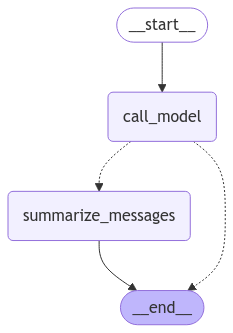

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

workflow = StateGraph(State)

workflow.add_node("call_model", call_model)
workflow.add_node("summarize_messages", summarize_messages)


workflow.add_edge(START, "call_model")
workflow.add_conditional_edges("call_model", should_continue)
workflow.add_edge("summarize_messages", END)

graph = workflow.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable" : {"thread_id" : "123"}}


input_message = [HumanMessage(content="Hello, I am Hrithik?")]
output = graph.invoke({"messages" : input_message}, config)
for message in output["messages"]:
    message.pretty_print()


================================ Human Message =================================

Hello, I am Hrithik?
================================== Ai Message ==================================

Hello Hrithik! How can I assist you today?


In [15]:
input_message = [HumanMessage(content="What is my name?")]
output = graph.invoke({"messages" : input_message}, config)
for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello, I am Hrithik?
================================== Ai Message ==================================

Hello Hrithik! How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Hrithik. How can I help you today?


In [16]:
input_message = [HumanMessage(content="I like Golden State Warriors!")]
output = graph.invoke({"messages" : input_message}, config)
for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello, I am Hrithik?
================================== Ai Message ==================================

Hello Hrithik! How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Hrithik. How can I help you today?
================================ Human Message =================================

I like Golden State Warriors!
================================== Ai Message ==================================

Great choice! The Golden State Warriors have a rich history and a strong fan base. Do you have a favorite player or moment from the team?


In [17]:
graph.get_state(config).values.get("summary", "")

''

In [18]:
input_message = [HumanMessage(content="I am huge fan of Stephen Curry! Isnt he the one with highest 3 point shots?")]
output = graph.invoke({"messages" : input_message}, config)
for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

I am huge fan of Stephen Curry! Isnt he the one with highest 3 point shots?
================================== Ai Message ==================================

Yes, that's correct! Stephen Curry is widely regarded as one of the greatest shooters in NBA history, and he holds the record for the most three-point field goals made in the regular season. His ability to shoot from long range has transformed the game and inspired many players to develop their three-point shooting skills. What do you like most about his game?


In [27]:
import textwrap

summary = output["summary"]
textwrap.fill(summary, width=80)


'In the conversation, you introduced yourself as Hrithik and mentioned that you\nare a fan of the Golden State Warriors, particularly Stephen Curry. I confirmed\nthat Curry holds the record for the most three-point shots made in NBA history\nand asked what you like most about his game.'